In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Input, concatenate
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
import numpy as np

In [4]:
#Separate dates for future plotting
load = pd.read_csv('./dataset_train_4_0to200.csv')



In [5]:
# Removing "," from columns "Load in Houston" , "Ercot Load" and "Settlement Point Price"
load['Load in Houston'] = load['Load in Houston'].astype(str).str.replace(r',', '')
#load['Ercot Load'] = load['Ercot Load'].astype(str).str.replace(r',', '')
load['Settlement Point Price'] = load['Settlement Point Price'].astype(str).str.replace(r',', '')
load.head()

,Delivery Date,Delivery Hour,Repeated Hour Flag,Settlement Point Name,Settlement Point Type,DayStatus,Temperature in F,Load in Houston,Settlement Point Price
0,1/1/2015,1,N,LZ_HOUSTON,LZ,Public Holiday,44,9844.2,22.47
1,1/1/2015,2,N,LZ_HOUSTON,LZ,Public Holiday,44,9653.46,22.31
2,1/1/2015,3,N,LZ_HOUSTON,LZ,Public Holiday,44,9502.3,22.2
3,1/1/2015,4,N,LZ_HOUSTON,LZ,Public Holiday,44,9474.48,22.13
4,1/1/2015,5,N,LZ_HOUSTON,LZ,Public Holiday,44,9554.37,22.16


In [6]:
load['Settlement Point Price'] = load['Settlement Point Price'].astype(float)
load['Temperature in F'] = load['Temperature in F'].astype(float)
load['Load in Houston'] = load['Load in Houston'].astype(float)
#load['Ercot Load'] = load['Ercot Load'].astype(float)
load['Settlement Point Price'] = round(load['Settlement Point Price'],2)
load.dtypes
dataset = load.values

In [7]:
load.dtypes

import datetime
load['year'] = pd.DatetimeIndex(load['Delivery Date']).year
load['day'] = pd.DatetimeIndex(load['Delivery Date']).day# Extracting Day from "Delivery Date"
load['month'] = pd.DatetimeIndex(load['Delivery Date']).month   # Extracting Month from "Delivery Date"


a = load['Delivery Date']
a= pd.to_datetime(a)

load['dayofweek'] = a.dt.dayofweek
load['dayofweek'] 

0        3
1        3
2        3
3        3
4        3
        ..
34633    0
34634    0
34635    0
34636    0
34637    0
Name: dayofweek, Length: 34638, dtype: int64

In [8]:
load['year'] = pd.DatetimeIndex(load['Delivery Date']).year

In [9]:
load = load.set_index(['Delivery Date']) 
load = load.drop(columns=['year','day','Settlement Point Name','Settlement Point Type'], axis=1)  
# Re-arranging Columns
load = load[['dayofweek','month','Delivery Hour','Temperature in F','Load in Houston', 'Settlement Point Price']]
load.head()

,dayofweek,month,Delivery Hour,Temperature in F,Load in Houston,Settlement Point Price
Delivery Date,,,,,,
1/1/2015,3,1,1,44.0,9844.20,22.47
1/1/2015,3,1,2,44.0,9653.46,22.31
1/1/2015,3,1,3,44.0,9502.30,22.20
1/1/2015,3,1,4,44.0,9474.48,22.13
1/1/2015,3,1,5,44.0,9554.37,22.16


In [10]:

#Variables for training
cols = list(load)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['month', 'Delivery Hour', 'Temperature in F', 'Load in Houston', 'Settlement Point Price']


In [11]:
load.head()

,dayofweek,month,Delivery Hour,Temperature in F,Load in Houston,Settlement Point Price
Delivery Date,,,,,,
1/1/2015,3,1,1,44.0,9844.20,22.47
1/1/2015,3,1,2,44.0,9653.46,22.31
1/1/2015,3,1,3,44.0,9502.30,22.20
1/1/2015,3,1,4,44.0,9474.48,22.13
1/1/2015,3,1,5,44.0,9554.37,22.16


In [12]:
def train_time_series_with_folds(df, horizon=24*7):
    X = df.drop('Settlement Point Price', axis=1)
    y = df['Settlement Point Price']
    
    #take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    #create, train and do inference of the model
    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    #calculate MAE
    error = np.round(predictions,2) - np.round(y_test,2)
    i=0
    count=0
    for i in range(len(error)):
        if ((error[i])>5) or ((error[i]<-5)):
            count=count+1
    a = len(predictions) - count
    accuracy = (a/len(predictions))*100
    print('accuracy:', accuracy)
    mae = np.round(mean_absolute_error(y_test, predictions), 3)    
    mse_lstm = mean_squared_error(y_test, predictions)
    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,8))
    plt.title(f'Real vs Prediction - MAE {mae}-MSE{mse_lstm}- accuracy{accuracy}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predictions, index=y_test.index), color='green')
    plt.xlabel('Hour', fontsize=16)
    plt.ylabel('Number of Shared Bikes', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()
    
    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    #plot variable importances of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
    plt.show()
    
    for j in range(1,11):    
        i=0
        count=0
        for i in range(len(error)):
            if ((error[i])>j) or ((error[i]<-j)):
                count=count+1
        a = len(predictions) - count
        accuracy = (a/len(predictions))*100
        print("accuracy: with threshold of %i"%j," is %.2f"%accuracy)


accuracy: 64.28571428571429


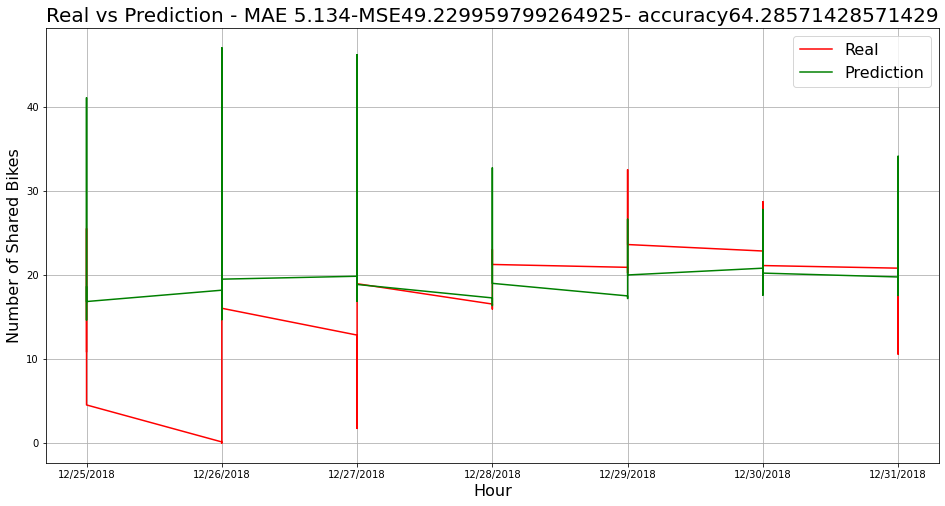

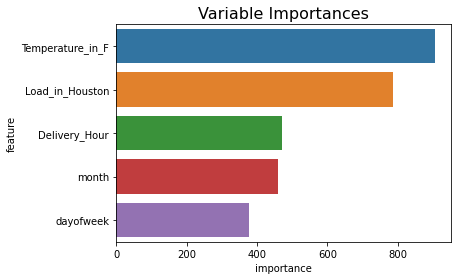

accuracy: with threshold of 1  is 17.86
accuracy: with threshold of 2  is 29.17
accuracy: with threshold of 3  is 39.88
accuracy: with threshold of 4  is 54.76
accuracy: with threshold of 5  is 64.29
accuracy: with threshold of 6  is 70.83
accuracy: with threshold of 7  is 76.19
accuracy: with threshold of 8  is 80.95
accuracy: with threshold of 9  is 82.74
accuracy: with threshold of 10  is 86.31


In [14]:
train_time_series_with_folds(load)